In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
np.random.seed(7)

In [ ]:
path = 'airline-passengers.csv'

In [ ]:
df = pd.read_csv(path)
df.drop(columns='Month', inplace=True)
df.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [ ]:
# df['lagged'] = df['Passengers'].shift(1)
# df.plot(y = 'lagged', kind = 'line')

In [ ]:
data = df.values.astype('float32')
data[:5,]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data = scaler.fit_transform(data)
data[:5,]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [ ]:
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
train[:5,]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [ ]:
test[:5,]

array([[0.4073359 ],
       [0.3803089 ],
       [0.48648646],
       [0.47104248],
       [0.484556  ]], dtype=float32)

In [ ]:
def generate_data(dataset,lag):
    dataX, dataY=[], []
    for i in range(len(dataset)-lag-1):
        a=dataset[i:(i+lag), 0]
        dataX.append(a)
        dataY.append(dataset[i+lag,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
lag=1
trainX,trainY= generate_data(train, lag)
testX,testY=generate_data(test, lag)

In [ ]:
trainX[:5,]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [ ]:
trainY[:5,]

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557],
      dtype=float32)

In [ ]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100,input_shape=(1,lag)))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
history = model.fit(trainX,trainY,epochs=50,validation_data=(testX, testY),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30)],batch_size=1,verbose=2)


Train on 94 samples, validate on 46 samples
Epoch 1/50
 - 1s - loss: 0.0265 - val_loss: 0.1119
Epoch 2/50
 - 0s - loss: 0.0107 - val_loss: 0.0709
Epoch 3/50
 - 1s - loss: 0.0078 - val_loss: 0.0516
Epoch 4/50
 - 0s - loss: 0.0050 - val_loss: 0.0302
Epoch 5/50
 - 1s - loss: 0.0034 - val_loss: 0.0119
Epoch 6/50
 - 0s - loss: 0.0025 - val_loss: 0.0103
Epoch 7/50
 - 0s - loss: 0.0022 - val_loss: 0.0089
Epoch 8/50
 - 0s - loss: 0.0022 - val_loss: 0.0092
Epoch 9/50
 - 0s - loss: 0.0021 - val_loss: 0.0094
Epoch 10/50
 - 0s - loss: 0.0021 - val_loss: 0.0097
Epoch 11/50
 - 0s - loss: 0.0024 - val_loss: 0.0093
Epoch 12/50
 - 0s - loss: 0.0021 - val_loss: 0.0093
Epoch 13/50
 - 0s - loss: 0.0023 - val_loss: 0.0091
Epoch 14/50
 - 0s - loss: 0.0023 - val_loss: 0.0094
Epoch 15/50
 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 16/50
 - 0s - loss: 0.0021 - val_loss: 0.0092
Epoch 17/50
 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 18/50
 - 1s - loss: 0.0022 - val_loss: 0.0094
Epoch 19/50
 - 1s - loss: 0.

In [ ]:
trainPredict=model.predict(trainX)
testPredict=model.predict(testX)

In [ ]:
trainPredict=scaler.inverse_transform(trainPredict)
trainY=scaler.inverse_transform([trainY])
testPredict=scaler.inverse_transform(testPredict)
testY=scaler.inverse_transform([testY])

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print('Train Score: %.2f RMSE' %(trainScore))
testScore = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print('Test Score: %.2f RMSE' %(testScore))

Train Score: 23.29 RMSE
Test Score: 49.47 RMSE


In [ ]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag,:] = trainPredict

In [ ]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+lag*2 + 1 : len(data)-1,:] = testPredict

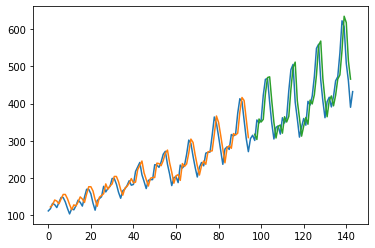

In [ ]:
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

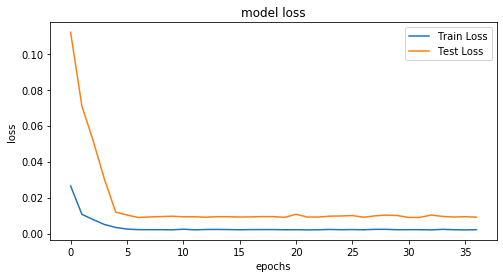

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();